This notebook is meant for the students of Basics of Applied Mathematics, in the master of Mathematics in Data and Technology, Freiburg Univsersity, 2024

# Programming Exercise for Homework 13

# Hand in: 28.01.2025

## Your task

This notebook containa some code snippets with missing lines that you will have to fill in! Please also try to read and understand the parts that you do not have to fill in to understand better how the code works.

# A guided exercise about the Logistic regression, with gradient descent

## Description 

### About the data

The dataset consists of 1797 images containing hand-written digits.

Each image is with 8 x 8 pixels, and is represented as a vector $a_j \in \mathbb{R}^{64}$.

Corresponding to that image, is a label $y_j \in \{ 0, 1, 2, ..., 9 \}$

Instead of dealing with $y_j \in \{0, ..., 9\}$, we prefer replace it with vectors $p_j \in \mathbb{R}^{10}$,
defined as follows:
$$
p_{j,l} = \begin{cases} 1 & \text{if } y_j=l \\   0 & \text{if } y_j\neq l \end{cases}
$$

### About the model 

The predictor $\varphi(a_j; x) \in \mathbb{R}^q$ is defined as follows:
$$
\varphi(a_j; x)_i = b_i + a_j^\top w_i
$$
with $x = (b_1, w_1, \dots, b_q, w_q)$


The goal is to have:
$$
\arg \max\limits_{i} \varphi(a_j; x)_i \approx y_j
$$

The probability predictor $\hat{p}(a_j; x)$ is defined as follows:
$$
\hat{p}(a_j; x) = \text{softmax}(\varphi(a_j; x))
$$

i.e.
$$
\hat{p}(a_j; x)_i = \frac{e^{\varphi(a_j; x)_i}   }{ \sum\limits_{l=1}^q    e^{\varphi(a_j; x)_l}  }
$$

We define the cross-entropy as follows:
$$
L(p_j, a_j, x) = -\sum_{l=1}^q p_{j,l} \log \left(\hat{p}(a_j; x) \right)
$$

The loss is as follows:
$$
f(x) = \frac{1}{m} \sum_{j=1}^m L(p_j, a_j, x) 
$$

### Simplifications for $L$:

$$
L(p_j, a_j, x) 
=   h(a_j, x) - \sum_{i=1}^q p_{j,i} \varphi(a_j; x)_i
$$

with $h(a_j, x) := \log \left(\sum\limits_{l=1}^q    e^{\varphi(a_j; x)_l} \right)$

## Imports

For this exercise, you will need to have scikit-learn installed on your machine.
For that purpose, you can for example use conda:

```
    conda install scikit-learn
```

In [1]:
import numpy as np # Package for array manipulations
import matplotlib.pyplot as plt # Package for plotting
from sklearn.datasets import load_digits # To load the data set

# Jupyter magic command to make the plots a bit nicer
%matplotlib notebook 
                     # replace with "%matplotlib inline" 
                     # in case one uses the VS code UI
                     # instead of the Jupyter UI
            
            

## Prepare the data

### Load the dataset

In [2]:
# Load a data set of Digits
digits = load_digits()
A_tot = digits.data
Y_tot = digits.target

m_tot = Y_tot.shape[0] # number of data points
q = 10 # q is the number of labels

<IPython.core.display.Javascript object>


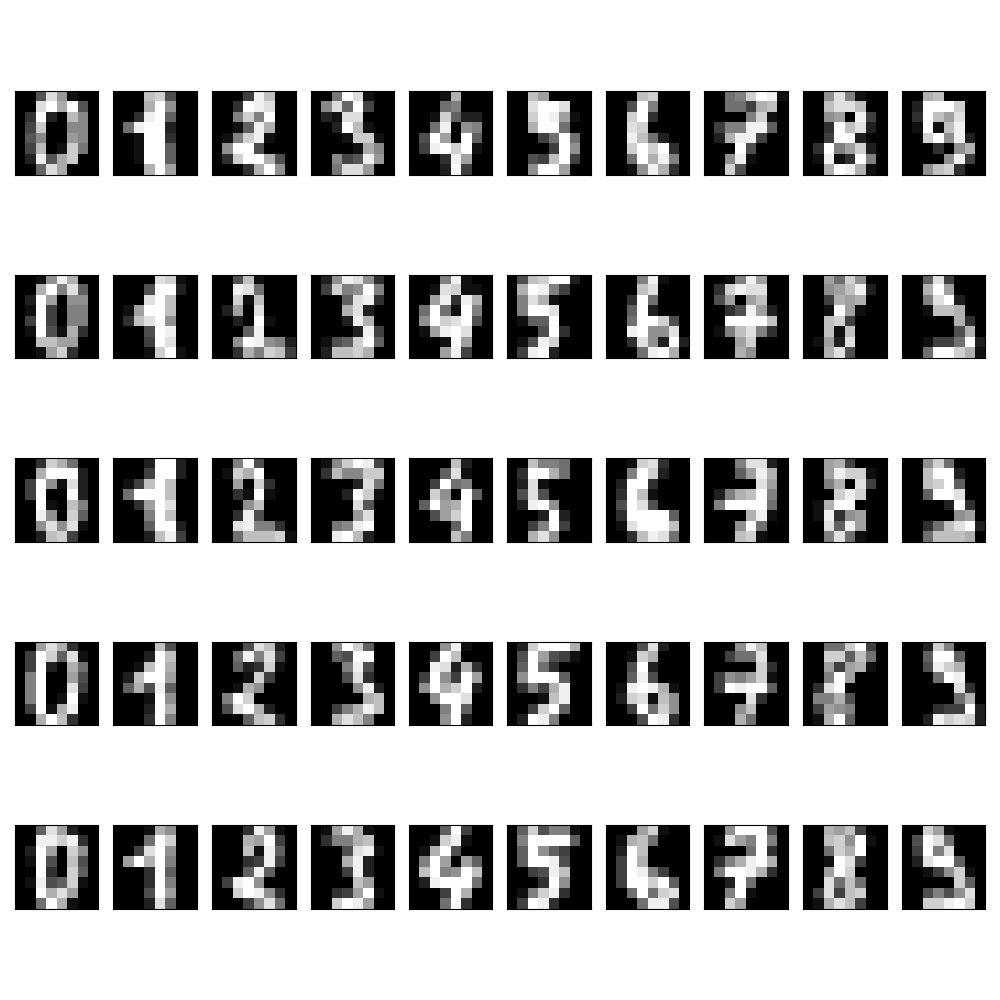

In [3]:
# Visualize some images from the dataset
m_example=5
fig, axs = plt.subplots(m_example, q, figsize=(10, 10))


for j in range(q):
    # j is the class, gos from 0 to 9
    data_this_label = A_tot[Y_tot==j] # all images from that class
    for i in range(m_example): # 5 examples from this class
        example = data_this_label[i].reshape((8,8))
        axs[i, j].set_xticks([]) # remove ticks to make plot more pretty
        axs[i, j].set_yticks([])
        axs[i, j].imshow(example, cmap=plt.cm.gray)
fig.tight_layout()

### Create P 

In [4]:
P_tot = np.zeros((m_tot, q), dtype=bool)
for l in range(q):
    samples = (Y_tot == l)
    P_tot[samples, l] = True

### Split the dataset in 2 parts: one for training, one for test

In [5]:
rng = np.random.default_rng(123) # random generator

p_tr = 0.6 # Probability to be in the training set
slice_tr = rng.random(m_tot) < p_tr # indices of the samples in the training dataset


slice_test = ~slice_tr # indices of the samples in the test set
A_tr, P_tr = A_tot[slice_tr], P_tot[slice_tr]
A_test, P_test = A_tot[slice_test], P_tot[slice_test]

m_tr = len(P_tr)
m_test = len(P_test)


## Write some functions

### Define the predictor

<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

Compute the number of optimization variables $n$
</div>

In [6]:
d = A_tr.shape[1]
# ----- YOUR CODE
n = (d+1) * q
# --------- END YOUR CODE

<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

Define the function $\varphi(a_j, x)$
</div>

In [7]:
def phi(A, x):
    # x is a array of size n
    # A is an array of size m x d
    # ----- YOUR CODE
    X = x.reshape((d+1, q))
    phi_value = A @ X[:-1] + X[-1]
    # --------- END YOUR CODE
    return phi_value # phi is of shape m x q

In [8]:
# This is the predictor
def label_predictor(A, x):
    y_pred = np.argmax(phi(A, x), axis=1)
    return y_pred

<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

Define the Softmax function
</div>

In [9]:
def softmax(arr):
    # arr is of shape a x b
    # ----- YOUR CODE
    exp = np.exp(arr)
    sum_exp = np.sum(exp, axis=1)
    sm = exp / sum_exp[:, None]
    # --------- END YOUR CODE
    return sm # shape is a


<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

Define the function H
</div>

In [10]:
def H(A, x):
    # ----- YOUR CODE
    phi_val = phi(A, x)
    H_val = np.log(np.sum(np.exp(phi_val), axis=1) )
    # --------- END YOUR CODE
    return H_val

### Define the Logistic loss

In [11]:
# value of the loss f(x)  (nothing to do here)
def loss(A, P, x):
    # P is a matrix of size m x q
    L = H(A, x)  - np.einsum("mq,mq->m", P, phi(A, x)) 
    f_value = np.mean(L)
    return f_value

### Compute the gradient 

In [12]:
# Gradient of the predictor phi (nothing to do here)
def nabla_phi(A):
    m = A.shape[0]
    dphi_dX = np.zeros((m, q, (d+1), q))
    for i in range(q):
        dphi_dX[:, i, :-1, i] = A
        dphi_dX[:, i, -1, i] = 1
    dphi_dx = dphi_dX.reshape((m, q, n))
    return dphi_dx

In [13]:
# Gradient of the loss nabla f(x) (nothing to do here)
def gradient(A, P, x, grad_phi=None):
    if grad_phi is None:
        # Nice to be able to precompute instead constructing the matrix at every iteration.
        grad_phi = nabla_phi(A) # shape:  m x q x n

    phi_val = phi(A, x)   # shape:  m x q
    grad_H = np.einsum( "mq,mqn->mn", softmax(phi_val), grad_phi) # shape: m x n
    grad_L = grad_H - np.einsum("mq,mqn->mn", P, grad_phi)  # shape: m x n
    grad_f = np.mean(grad_L, axis=0) # shape: n
    return grad_f

In [14]:
grad_phi_tr = nabla_phi(A_tr)
def nabla_f(x):
    return gradient(A_tr, P_tr, x, grad_phi=grad_phi_tr)

### Gradient descent

<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

The gradient descent algorithm with a fixed step size $\alpha$
</div>

In [15]:
def GD(x0, iter_max=100, alpha=0.1):
    iterates = []
    xk = x0.copy()
    for k in range(1, iter_max):
        # ----- YOUR CODE
        dk = -nabla_f(xk)
        xk = xk + alpha * dk
        # --------- END YOUR CODE
        iterates.append(xk.copy())
    return iterates

## Solving the problem

### Run GD with default settings 

In [16]:
x0 = np.zeros(n)
iterates = GD(x0)

### Plot value function

In [17]:
loss_training = [
    loss(A_tr, P_tr, xk) for xk in iterates
]
loss_test =  [
    loss(A_test, P_test, xk) for xk in iterates
]

<IPython.core.display.Javascript object>


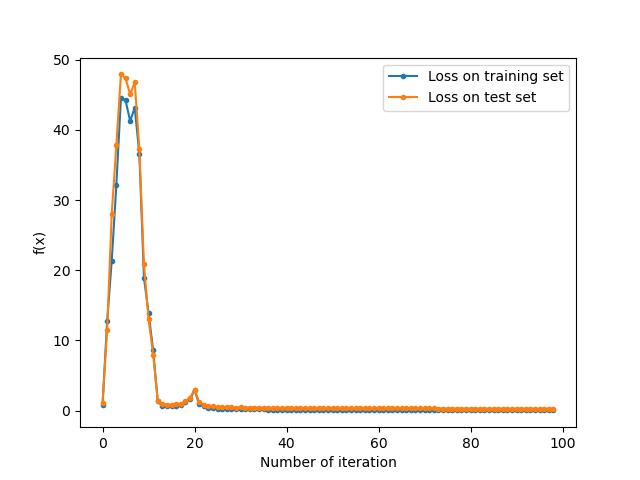

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of iteration")
ax.set_ylabel("f(x)")
iters = np.arange(len(iterates))
ax.plot(iters, loss_training, ".-", label="Loss on training set")
ax.plot(iters, loss_test, ".-", label="Loss on test set")
ax.legend()

<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

Comment the plot
</div> 

### Predictions on training and test data

In [19]:
x_sol = iterates[-1]

In [20]:
pred_tr = label_predictor(A_tr, x_sol)
success_tr = P_tr[np.arange(m_tr), pred_tr]
n_errors_tr = np.sum(~success_tr)
print(f"classification errors (training data) = {n_errors_tr / len(P_tr) * 100:.1f} %")

classification errors (training data) = 1.3 %


In [21]:
pred_test = label_predictor(A_test, x_sol)
success_test = P_test[np.arange(m_test), pred_test]
n_errors_test = np.sum(~success_test)
print(f"classification errors (test data) = {n_errors_test / len(P_test) * 100:.1f} %")

classification errors (test data) = 4.9 %


<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

Comment the results
</div> 

### Visualize the solution

In [22]:
n_examples = 10
fig, axs = plt.subplots(1, n_examples, figsize=(15, 3))

for i in range(n_examples):
    j = np.random.randint(m_test)
    img = A_test[j].reshape((8,8))
    y_pred = label_predictor(A_test[j:j+1,:], x_sol).squeeze()
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].imshow(img, cmap=plt.cm.gray)
    axs[i].set_title(f"pred={y_pred}")
fig.tight_layout()

<IPython.core.display.Javascript object>

## Different step-size

### Run GD with different step sizes 

In [23]:
iterates_dict = {}
for alpha in [0.2, 0.1, 0.05, 0.02]:
    x0 = np.zeros(n)
    iterates_dict[alpha] = GD(x0, alpha=alpha)

### Plot value function

<IPython.core.display.Javascript object>


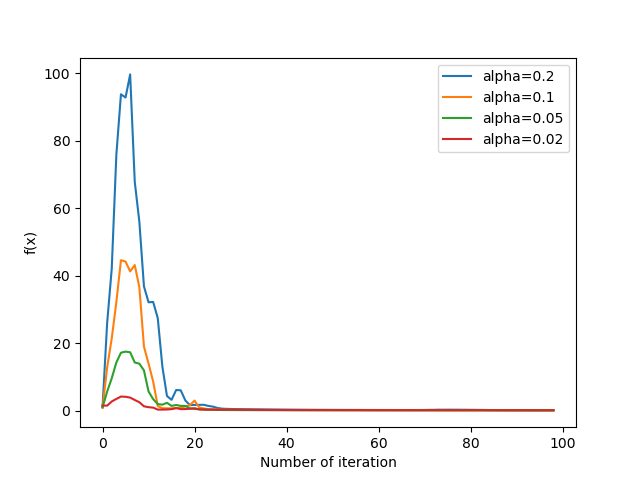

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of iteration")
ax.set_ylabel("f(x)")
for alpha, it in iterates_dict.items():
    loss_training = [ loss(A_tr, P_tr, xk) for xk in it ]
    ax.plot(np.arange(len(it)), loss_training, "-", label=f"alpha={alpha}")
ax.legend()


<IPython.core.display.Javascript object>


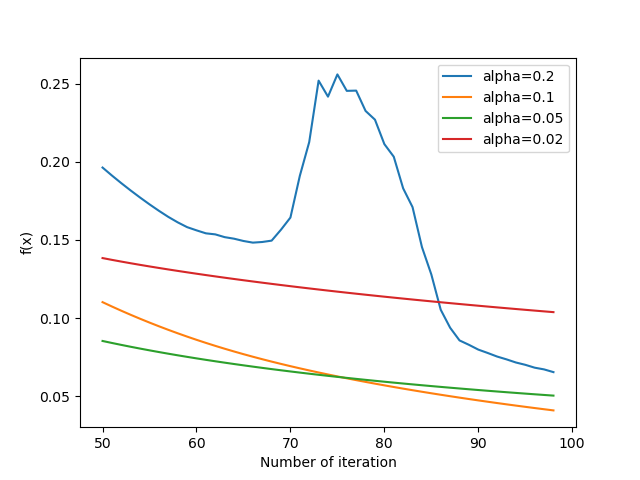

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of iteration")
ax.set_ylabel("f(x)")
for alpha, it in iterates_dict.items():
    loss_training = [ loss(A_tr, P_tr, xk) for xk in it ]
    ax.plot(np.arange(len(it))[50:], loss_training[50:], "-", label=f"alpha={alpha}")
ax.legend()

<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

Comment the plots
</div> 

## Incorporate globalization

### Define GD with backtracking linesearch

In [26]:
def f(x):
    return loss(A_tr, P_tr, x)

<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

Complete the following function for the backtracking line-search algorithm.
</div> 

To simplify things, instead of using the Armijo criterion, the criterion for acceptance of a step is simply to decrease the cost:
$$
f(x_k + \alpha_k d_k) \leq f(x_k)
$$

In [27]:
def backtracking_linesearch(x, d, alpha_max=1., beta=0.9, max_iter=50):
    alpha = alpha_max
    for i in range(max_iter):
        # ----- YOUR CODE
        if f(x + alpha * d) <= f(x):
            break
        # --------- END YOUR CODE
        alpha = alpha * beta
    return alpha

In [28]:
def GD_with_backtracking(x0, iter_max=100):
    iterates = []
    xk = x0.copy()
    for k in range(1, iter_max):
        # ----- YOUR CODE
        dk = -nabla_f(xk)
        alpha = backtracking_linesearch(xk, dk)
        xk = xk + alpha * dk
        # --------- END YOUR CODE
        iterates.append(xk.copy())
    return iterates

### Run GD with backtracking linesearch

In [29]:
x0 = np.zeros(n)
iterates_bt = GD_with_backtracking(x0)

### Plot value function

<IPython.core.display.Javascript object>


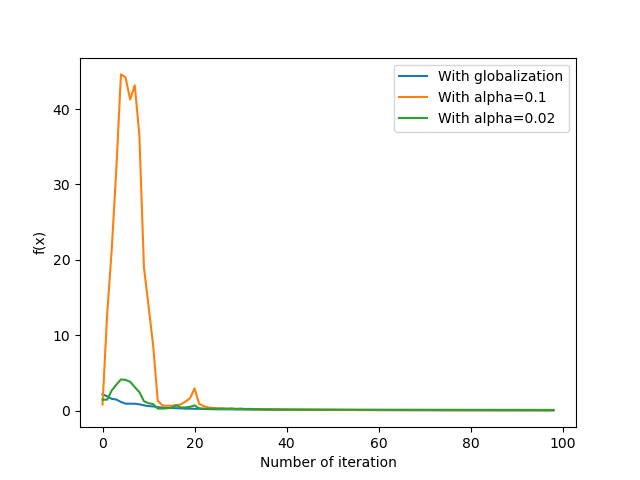

In [30]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of iteration")
ax.set_ylabel("f(x)")
ax.plot(np.arange(len(iterates_bt)), [f(xk) for xk in iterates_bt ], "-", label="With globalization")
for alpha in [0.1, 0.02]:
    iterates_ = iterates_dict[alpha]
    ax.plot(np.arange(len(iterates_)), [f(xk) for xk in iterates_], "-", label=f"With alpha={alpha}")
ax.legend()

<IPython.core.display.Javascript object>


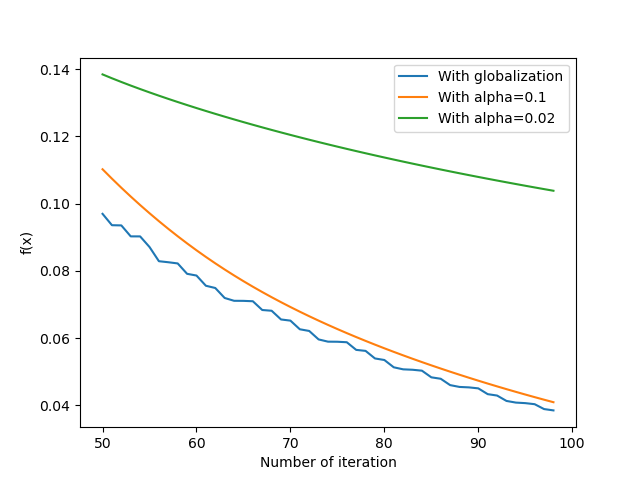

In [31]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of iteration")
ax.set_ylabel("f(x)")
ax.plot(np.arange(len(iterates_bt))[50:], [f(xk) for xk in iterates_bt[50:] ], "-", label="With globalization")
for alpha in [0.1, 0.02]:
    iterates_ = iterates_dict[alpha]
    ax.plot(np.arange(len(iterates_))[50:], [f(xk) for xk in iterates_[50:] ], "-", label=f"With alpha={alpha}")
ax.legend()

<hr/>
<div class="alert alert-block alert-info">
   
**Task:**

Comment the plot
</div> 